In [1]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

### To download data for the stocks
Symbols = ["AAPL","GOOGL","FB"]
start = datetime.datetime(2020,2,1)
end = datetime.datetime(2020,10,11)

stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=True)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
        

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
# This contains data for all the stocks
stock_final.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-01-31,80.232498,80.669998,77.072502,77.377502,76.244965,199588400,AAPL
2020-02-03,76.074997,78.372498,75.555000,77.165001,76.035576,173788400,AAPL
2020-02-04,78.827499,79.910004,78.407501,79.712502,78.545776,136616400,AAPL
2020-02-05,80.879997,81.190002,79.737503,80.362503,79.186264,118826800,AAPL
2020-02-06,80.642502,81.305000,80.065002,81.302498,80.112503,105425600,AAPL


In [3]:
#Seperate the data for each stock/company
google = stock_final[stock_final["Name"]=="GOOGL"]
google.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-01-31,1467.859985,1469.670044,1427.060059,1432.780029,1432.780029,2191100,GOOGL
2020-02-03,1461.650024,1486.300049,1456.609985,1482.599976,1482.599976,3581800,GOOGL
2020-02-04,1454.489990,1467.339966,1422.030029,1445.410034,1445.410034,4794000,GOOGL
2020-02-05,1463.609985,1464.579956,1429.680054,1446.050049,1446.050049,1818800,GOOGL
2020-02-06,1451.979980,1481.560059,1450.479980,1475.969971,1475.969971,1891100,GOOGL


In [4]:
facebook = stock_final[stock_final["Name"]=="FB"]
facebook.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-01-31,208.429993,208.690002,201.059998,201.910004,201.910004,31359900,FB
2020-02-03,203.440002,205.139999,202.500000,204.190002,204.190002,15495600,FB
2020-02-04,206.619995,210.600006,205.199997,209.830002,209.830002,19628900,FB
2020-02-05,212.509995,212.729996,208.710007,210.110001,210.110001,12538200,FB
2020-02-06,210.470001,211.190002,209.339996,210.850006,210.850006,10567500,FB


In [5]:
apple = stock_final[stock_final["Name"]=="AAPL"]
apple.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-01-31,80.232498,80.669998,77.072502,77.377502,76.244965,199588400,AAPL
2020-02-03,76.074997,78.372498,75.555000,77.165001,76.035576,173788400,AAPL
2020-02-04,78.827499,79.910004,78.407501,79.712502,78.545776,136616400,AAPL
2020-02-05,80.879997,81.190002,79.737503,80.362503,79.186264,118826800,AAPL
2020-02-06,80.642502,81.305000,80.065002,81.302498,80.112503,105425600,AAPL


#### Studying the spread between each pair of stocks

In [26]:
AF_spread = apple.Close - facebook.Close

In [27]:
AG_spread = apple.Close - google.Close

In [28]:
GF_spread = google.Close - facebook.Close

In [29]:
AF_spread.head()

Date
2020-01-31   -124.532501
2020-02-03   -127.025002
2020-02-04   -130.117500
2020-02-05   -129.747498
2020-02-06   -129.547508
Name: Close, dtype: float64

In [14]:
## the most cointegrated pair
stock1 = pd.read_csv('data/2021-december/PKI.csv')
stock2 = pd.read_csv('data/2021-december/S.csv')
beta = 3.8312600785683832

In [18]:
spread = stock1.Close - beta * stock2.Close

### Checking for stationarity over spreads

In [19]:
import matplotlib.pyplot as plt

The mean of the spread is : 0.21564519689464448


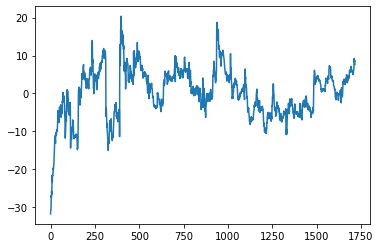

In [20]:
print("The mean of the spread is :",spread.mean())
plt.plot(spread)
plt.show()

The mean of the spread is : -1320.6718361160972


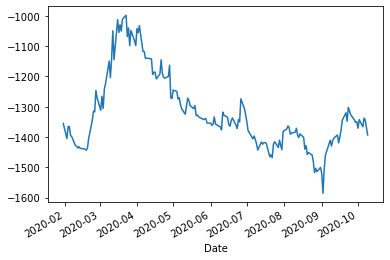

In [32]:
print("The mean of the spread is :",AG_spread.mean())
AG_spread.plot()
plt.show()

The mean of the spread is : 1186.502104845914


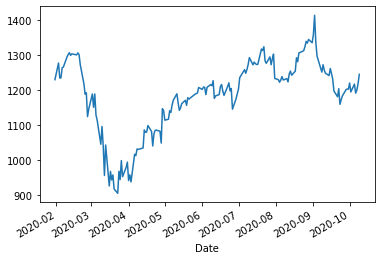

In [33]:
print("The mean of the spread is :",GF_spread.mean())
GF_spread.plot()
plt.show()

#### ADFULLER TEST

In [21]:

from statsmodels.tsa.stattools import adfuller
result = adfuller(spread)

In [22]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.503918
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


#### The most cointegrated pair based on the data of 2021-12-28 is ('BBBY', 'MCK')

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from collections import deque
import random
import pandas as pd
import numpy as np
import torch.optim as optim

In [24]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining network to optimize our Q function
        self.input = nn.Linear(30,256)
        self.dense1 = nn.Linear(256,60)
        self.out = nn.Linear(60, 3)
    ## Forward propagation
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.out(x)
     
        return x
    ## Train model
    def train(self,X,Y):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        running_loss = 0.0
        for i in range(len(X)):
            inputs, labels= torch.FloatTensor(X[i]), torch.FloatTensor(Y[i])
            optimizer.zero_grad()
            out = self(inputs)
            loss = criterion(out, torch.FloatTensor(Y[i]))
            loss.backward()          ## This does back propagation
            optimizer.step()         ## To optimize loss function 
            running_loss+=loss.item()  ## the value of the loss function after training
        
        return running_loss
    
    

In [25]:
class Agent:
    def __init__(self, state_size,window_size,trend, skip,batch_size,stock1,stock2):
        self.stock1 = stock1
        self.stock2 = stock2
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3 
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.model = DQN()
    def act(self,state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return torch.argmax(self.model(torch.FloatTensor(state)))
    
    def get_state(self,t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def buy(self,initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 sell 2 at difference %f, total balance %f'% (t, self.trend[t], initial_money))
                
            elif action == 2 and initial_money >= -self.trend[t]:
                initial_money += self.trend[t]
                states_sell.append(t)
                print('day %d: buy 2 sell 1 at difference %f, total balance %f'% (t, self.trend[t], initial_money))
                
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def replay(self,batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l-batch_size,l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.model(torch.FloatTensor(states)).tolist()
        Q_new = self.model(torch.FloatTensor(new_states)).tolist()

        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            
            if not done:
                target[action] += self.gamma * max(Q_new[i])
            X[i] = state
            Y[i] = target
        cost = self.model.train(X,Y)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def train(self, iterations, checkpoint, initial_money,):
        for i in range(iterations):
            total_profit = 0
            inventory1 = [self.stock1[0]]
            inventory2 = []
            state = self.get_state(0)
            starting_money = initial_money - self.stock1[0]
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and len(inventory2)>0 and t < (len(self.trend) - self.half_window):
                    bought_price = inventory2.pop(0)
                    starting_money -= self.trend[t]
                    total_profit = total_profit - self.trend[t] - bought_price 
                    
                elif action == 2 and starting_money >= -self.trend[t] and len(inventory1)>0 and t < (len(self.trend) - self.half_window):
                    bought_price = inventory1.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)    
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))               
                

In [26]:
beta

3.8312600785683832

In [138]:
## Action 1: Buy first Sell second
## Action 2: Buy second Sell first
## Difference is first-second

In [31]:
close = spread.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
stock1 = pd.read_csv('data/2021-december/PKI.csv').Close.tolist()
stock2 = pd.read_csv('data/2021-december/S.csv').Close.tolist()
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size,
               stock1 = stock1,
             stock2 = stock2)

In [32]:
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -186.313661.3, cost: 0.000001, total money: 9813.686339
epoch: 20, total rewards: -206.966344.3, cost: 0.000001, total money: 9793.033656
epoch: 30, total rewards: -191.914285.3, cost: 0.000001, total money: 9808.085715
epoch: 40, total rewards: -171.732956.3, cost: 0.000001, total money: 9828.267044
epoch: 50, total rewards: -194.386561.3, cost: 0.000001, total money: 9805.613439
epoch: 60, total rewards: -185.171447.3, cost: 0.000001, total money: 9814.828553
epoch: 70, total rewards: -186.659543.3, cost: 0.000027, total money: 9813.340457
epoch: 80, total rewards: -179.732420.3, cost: 0.000032, total money: 9820.267580
epoch: 90, total rewards: -174.970480.3, cost: 0.000001, total money: 9825.029520
epoch: 100, total rewards: -192.392608.3, cost: 0.000001, total money: 9807.607392
epoch: 110, total rewards: -166.735827.3, cost: 0.000001, total money: 9833.264173
epoch: 120, total rewards: -175.784614.3, cost: 0.000085, total money: 9824.215386
epoch: 130, t

In [33]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 sell 2 at difference -31.740377, total balance 10031.740377
day 1: buy 1 sell 2 at difference -30.982804, total balance 10062.723181
day 2: buy 1 sell 2 at difference -30.852050, total balance 10093.575231
day 3: buy 1 sell 2 at difference -29.820643, total balance 10123.395874
day 4: buy 1 sell 2 at difference -26.876347, total balance 10150.272221
day 5: buy 1 sell 2 at difference -27.424491, total balance 10177.696712
day 6: buy 1 sell 2 at difference -25.749884, total balance 10203.446595
day 7: buy 1 sell 2 at difference -26.598485, total balance 10230.045081
day 8: buy 1 sell 2 at difference -23.393970, total balance 10253.439051
day 9: buy 1 sell 2 at difference -21.571520, total balance 10275.010571
day 10: buy 1 sell 2 at difference -23.296792, total balance 10298.307363
day 11: buy 1 sell 2 at difference -21.546041, total balance 10319.853404
day 12: buy 1 sell 2 at difference -21.745793, total balance 10341.599197
day 13: buy 1 sell 2 at difference -20.990621, t

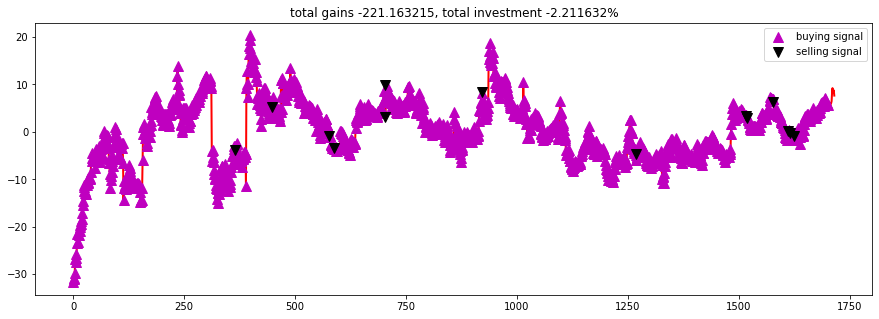

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend(), '^'
plt.show()

In [38]:
len(states_buy)

1684

In [40]:
len(states_sell)

14